In [17]:
#Import Data For Assingment 
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>% 
    group_by(character, episode_number) %>% 
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>% 
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

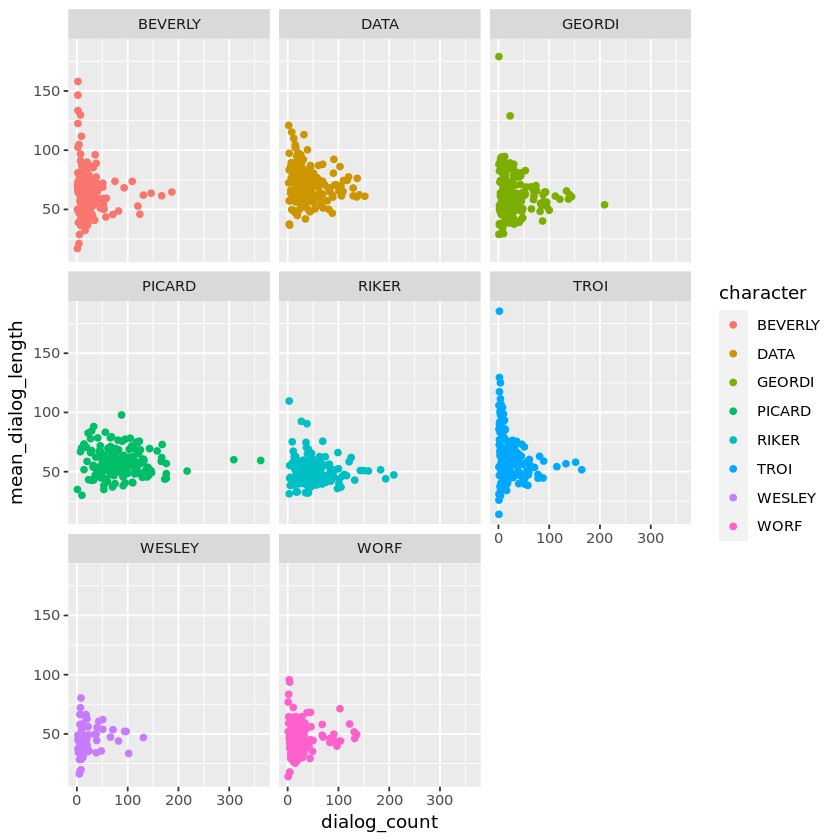

In [19]:
#Question 1: 
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + 
    geom_point(aes(color=character)) + 
    facet_wrap(~character)

#These plots enable an analysis of how much and how frequently characters speak. 
#Picard and Riker have consistently high dialog counts in comparison to other characters, indicating that they are main characters. 
#Picard has more varied dialog lengths and speaks more than Riker, indicating that he may be the lead character. 
#Beverly, Wesley, and Worf speak less often and have shorter mean dialog lengths than Riker and Picard, indicating they are supporting characters and may not appear as frequently in episodes.
#Geordi and Troi have more variability in their dialog length and dialog count, indicating that their importance varies between episodes, and they are supporting characters. 
#Data has relatively short dialogs and appears more often than Beverly, Wesley, and Worf, indicating a more central role, but still a supporting role to Picard and Riker. 
#Outlier points indicate that some episodes may have a specific character focus. 

In [20]:
#Question 2a: 
beverly_seasons <- dialogs_fixed %>%
  filter(
    character == "BEVERLY",
    episode_number >= 102 & episode_number <= 126 | episode_number >= 149 & episode_number <= 174
  ) %>%
  mutate(
    season = case_when(
      episode_number >= 102 & episode_number <= 126 ~ "Season 1",
      episode_number >= 149 & episode_number <= 174 ~ "Season 3"
    )
  ) %>%
  group_by(season, episode_number) %>%
  summarize(
    mean_dialog_length = mean(dialog_length),
    dialog_count = n(),
    .groups = "drop"
  )
beverly_summary <- beverly_seasons %>%
  group_by(season) %>%
  summarize(
    mean_of_mean_dialog_length = mean(mean_dialog_length),
    mean_dialog_count = mean(dialog_count),
    .groups = "drop"
  )
print(beverly_summary)

# A tibble: 2 × 3
  season   mean_of_mean_dialog_length mean_dialog_count
  <chr>                         <dbl>             <dbl>
1 Season 1                       56.5              25.4
2 Season 3                       67.0              19.6


In [21]:
#Question 2b: 
#In season 3, Beverly had a greater mean length of dialogue but spoke fewer lines overall in comparison to season 1.
#She reported that this made her feel like a male character which is reflected by the previous analysis in Question 1. 
#On average the supporting male characters in the show speak less often but have longer lines than the female characters (ignoring outliers).
#Additionally, due to traditional roles, the longer dialogue may have made her feel like a male character because they provide
#more substantial dialogue than female roles. 

In [22]:
#Question 3a: 
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

tokens <- dialogs_fixed %>%
  mutate(word_list = str_split(dialog, "\\s+")) %>%
  unnest(word_list) %>%
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),
    word = str_to_lower(word)
  ) %>%
  filter(word != "", !word %in% stop_words)

In [23]:
#Question 3b
vocab_summary <- tokens %>%
  group_by(character) %>%
  summarize(
    total_words = n(),
    unique_words = n_distinct(word),
    vocab_richness = unique_words / total_words
  ) %>%
  arrange(desc(vocab_richness))

print(vocab_summary)

# A tibble: 8 × 4
  character total_words unique_words vocab_richness
  <chr>           <int>        <int>          <dbl>
1 WESLEY           7601         2291          0.301
2 WORF            18820         4318          0.229
3 TROI            19450         4187          0.215
4 BEVERLY         22900         4875          0.213
5 DATA            45462         8593          0.189
6 GEORDI          31978         5465          0.171
7 RIKER           41827         6458          0.154
8 PICARD          79214         9272          0.117


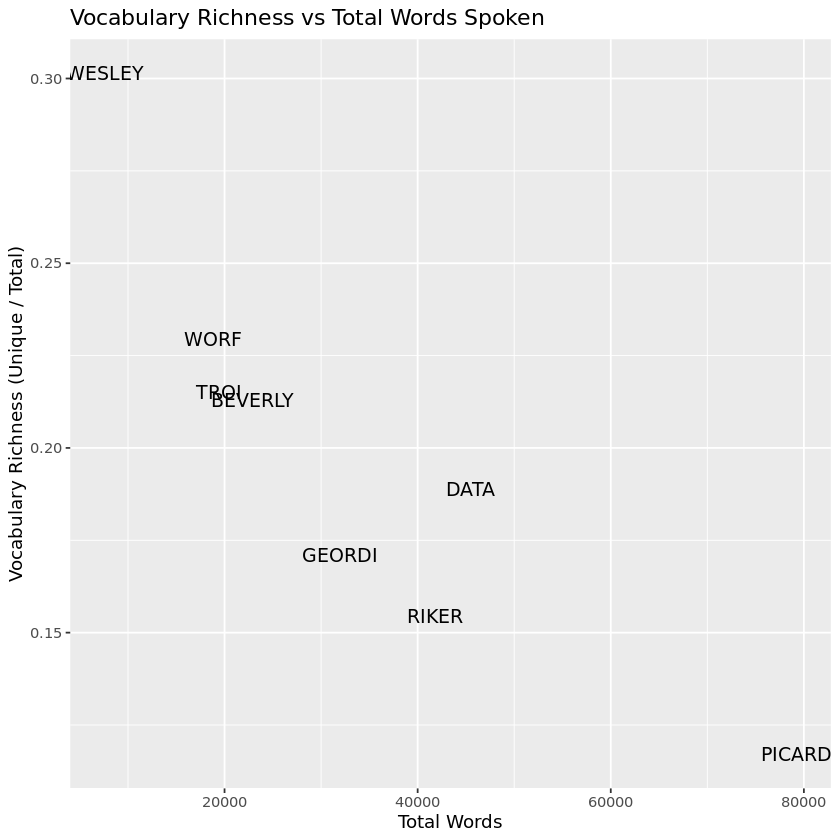

In [24]:
#Question 3c
ggplot(vocab_summary, aes(x = total_words, y = vocab_richness)) +
  geom_text(aes(label = character), size = 4) +  
  theme(legend.position = "none") +             
  labs(
    title = "Vocabulary Richness vs Total Words Spoken",
    x = "Total Words",
    y = "Vocabulary Richness (Unique / Total)"
  )

In [25]:
#Question 3d:
#The plot shows the tradeoff between how much a character speaks and the richness of their vocabulary. 
#Picard has the highest word count but the lowest richness, highlighting his main character role, but he often repeats the same language. 
#Wesley has the highest vocabulary richness but the lowest total words. This makes sense because the less often you speak, the higher the chance that your words and phrases are unique.
#It is reasonable to interpret that characters with higher total words and lower vocabulary richness are more central characters, and those with greater vocabulary richness and fewer total words are supporting characters. 

In [26]:
#Question 4a:
wesley_episodes <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number > 174) %>%
  group_by(episode_number) %>%
  summarize(dialog_count = n(), .groups = "drop") %>%
  arrange(episode_number)

print(wesley_episodes)

#Wesley left the main cast after episode 183, since he does not appear again until episode 206.

# A tibble: 11 × 2
   episode_number dialog_count
            <dbl>        <int>
 1            175           18
 2            176            6
 3            177            9
 4            178            6
 5            179           38
 6            181            2
 7            183           94
 8            206          131
 9            219           71
10            263           18
11            272           97


In [27]:
#Question 4b:
#Wesley makes a cameo appearance in episodes 206, 219, 261, and 272. 

In [28]:
#Question 4c: 
wesley_before_exit <- dialogs_fixed %>%
  filter(character == "WESLEY", episode_number <= 183) %>%
  arrange(episode_number, row_number()) %>%
  slice_tail(n = 1)
print(wesley_before_exit$dialog)
#Wesley's last line before leaving the main cast: "I can walk."

wesley_last_ever <- dialogs_fixed %>%
  filter(character == "WESLEY") %>%
  arrange(episode_number, row_number()) %>%
  slice_tail(n = 1)
print(wesley_last_ever$dialog)
#Wesley's final line: "Good-bye, Mom."

[1] "I can walk."
[1] "Good-bye, Mom."


Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)



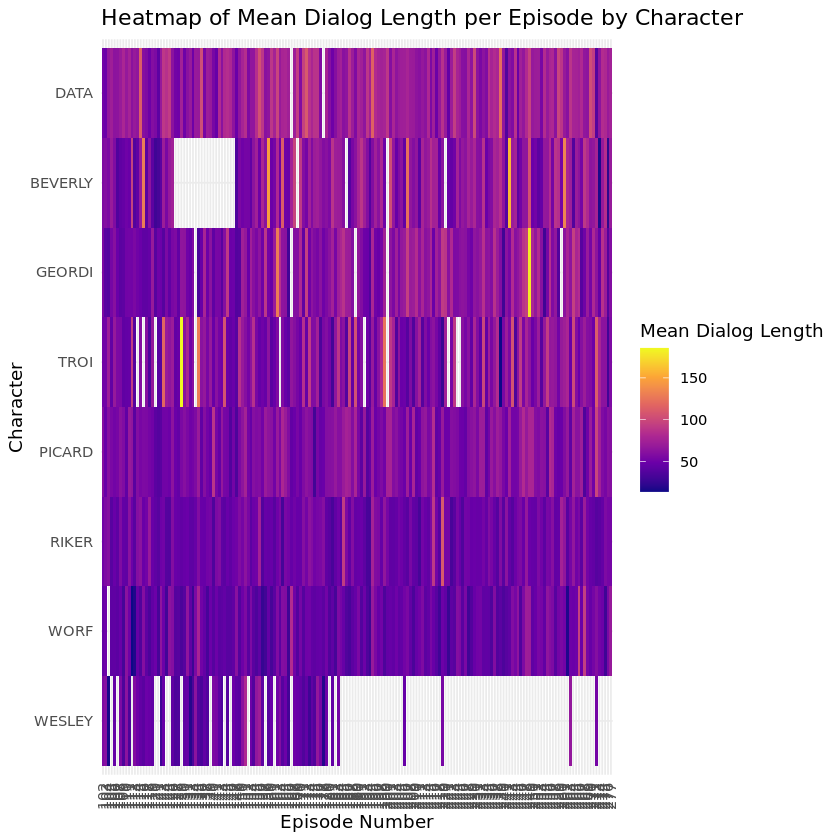

In [30]:
#Question 5:
install.packages("viridis")
library(viridis)

char_order <- dialog_len_per_ep %>%
  group_by(character) %>%
  summarize(overall_mean = mean(mean_dialog_length), .groups = "drop") %>%
  arrange(overall_mean) %>%
  pull(character)

dialog_len_per_ep <- dialog_len_per_ep %>%
  mutate(character = factor(character, levels = char_order))

ggplot(dialog_len_per_ep, aes(x = factor(episode_number), y = character, fill = mean_dialog_length)) +
  geom_tile() +
  scale_fill_viridis_c(option = "plasma") +
  labs(
    title = "Heatmap of Mean Dialog Length per Episode by Character",
    x = "Episode Number",
    y = "Character",
    fill = "Mean Dialog Length"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
        legend.position = "right")